In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt

from langevin.simulation import run_langevin_simulation
from langevin.analysis import compute_isf
from langevin.fitting import VFT_gamma, fit_model, two_step_stretched

In [33]:
#simulations parameters
dt = 1e-5
n_particles = 100
t_max = 1.
n_steps = int(t_max/dt)
m=1.0
gamma_l = 1.
kB=1.
tau = 1
q = 1000
T_ = np.arange(0.107,0.115,0.002)
T_0 = 0.1

In [34]:
Fs_ = []
time_lag_ = []

for i, T in enumerate(T_):
    start_ = time.time()
    
    gamma_g = VFT_gamma(T, T_0=T_0)

    # Run simulation
    positions, gamma_values, velocities = run_langevin_simulation(
        T=T,tau=tau, n_steps=n_steps,n_particles=n_particles,dt=dt,
        gamma_l=gamma_l,gamma_g=gamma_g,m=m,
        kB=kB,seed=2)
    
    # compute SISF
    t, F = compute_isf(positions, q=q, dt=dt, stride=10)
    
    # Store results
    Fs_.append(F)
    time_lag_.append(t)

    end_ = time.time()
    print(f"T = {T:.3f} | {end_ - start_:.2f} seconds")

T = 0.107 | 6.74 seconds
T = 0.109 | 6.46 seconds
T = 0.111 | 6.42 seconds
T = 0.113 | 6.49 seconds
T = 0.115 | 6.43 seconds


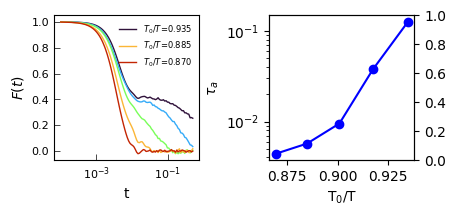

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.1))
#plt.subplot(1,2,1)
colors = plt.cm.turbo(np.linspace(0, 0.9, len(T_)))

decay_threshold=np.exp(-1)
tau_alpha = np.zeros(len(T_))
kww = np.zeros(len(T_))
for i in range(len(T_)):
    t_ = time_lag_[i]
    F_ = np.array(Fs_[i])
    #fit_params, fit_curve = fit_model(t_, F_, model_func= two_step_stretched, p0 = [1e-3, 1, 1, 0.5])      
    #print(fit_params)
    tau_alpha_idx = np.argmax(F_ < decay_threshold)
    tau_alpha[i] = t_[tau_alpha_idx] if tau_alpha_idx > 0 else None
    
    if (i % 3== 0) or i == len(T_) - 1:
        axs[0].plot(t_, F_, '-',ms=2, c=colors[i], alpha=1, label=fr'$T_0/T$={T_0/T_[i]:.3f}', lw=1)
        #axs[0].plot(t_, fit_curve, '-', c='black')
    else:
        axs[0].plot(t_, F_, '-', ms=2,c=colors[i], alpha=1, lw=1)
        #axs[0].plot(t_, fit_curve, '-', c='black')

axs[0].set_xlabel("t", fontsize=10)
axs[0].set_ylabel(r'$F(t)$', fontsize=10)
axs[0].set_xscale('log')
#axs[0].set_xlim(1e2, 2e5)
axs[0].legend(frameon=False, fontsize=6)
axs[0].tick_params(axis='both', which='major', labelsize=8, direction='in', length=4, width=0.5)
axs[0].tick_params(axis='both', which='minor', labelsize=8, direction='in', length=2, width=0.5)
#plt.xticks(np.logspace(-1, 3, 6))

# Second subplot (dual y-axis)
ax1 = axs[1]
ax2 = ax1.twinx() # Create a twin Axes sharing the x-axis


#plt.subplot(1,2,2)
ax1.plot(T_0/T_,tau_alpha,'-o',c='blue')
ax1.set_xlabel(r"T$_0$/T", fontsize=10)
ax1.set_ylabel(r'$\tau_a$', fontsize=10)
ax1.set_yscale('log')
#ax2.plot(T_0/T_,kww,'-o',c='red')
#ax2.set_ylim(0.9,2)
plt.tight_layout(pad=0.5)
plt.savefig('figs/Fig_ISF.pdf', dpi=300)
plt.show()